In [208]:
import numpy as np
import matplotlib.pyplot as plt

In [209]:
def generate_white_gaussian_noise(mean, std, num_samples):
    samples = np.random.normal(mean, std, size=num_samples)
    plt.plot(samples)
    plt.show()

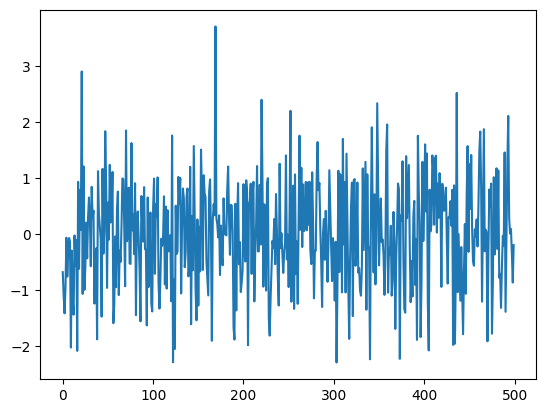

In [210]:
generate_white_gaussian_noise(0, 1, 500)

In [211]:
#mean = [0, 0, 1, -1]
#cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
#x0 = np.random.multivariate_normal(mean, cov, 1).T
#plt.plot(x, y, '.')
#plt.show()

In [212]:
x0.shape

(4, 1)

In [213]:
#plt.plot(x)
#plt.plot(y)
#plt.show()

In [214]:
N = 300
dt = 0.1

In [215]:
def state_system(t):
    A = [[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]]
    mean = [0, 0, 1, -1]
    cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
    mean2 = [0, 0, 0, 0]
    cov2 = [[(dt**3)/3, 0, (dt**2)/2, 0], [0, (dt**3)/3, 0, (dt**2)/2], [(dt**2)/2, 0, dt, 0], [0, (dt**2)/2, 0, dt]]
    L = [np.random.multivariate_normal(mean, cov, 1).T]
    for i in range(1, t):
        L.append(np.dot(A, L[i-1]) + np.random.multivariate_normal(mean2, cov2, 1).T)
    return L

In [216]:
state_system(N)

[array([[ 0.20128885],
        [ 1.33993245],
        [ 1.31998151],
        [-1.98519141]]),
 array([[ 0.34936526],
        [ 1.15000774],
        [ 1.72796256],
        [-1.6471679 ]]),
 array([[ 0.53418791],
        [ 1.01160156],
        [ 1.79184831],
        [-1.33813081]]),
 array([[ 0.70553463],
        [ 0.86269786],
        [ 1.66483421],
        [-1.53900872]]),
 array([[ 0.86621425],
        [ 0.73068834],
        [ 1.50955704],
        [-1.41098143]]),
 array([[ 1.0014064 ],
        [ 0.61181862],
        [ 1.47963103],
        [-0.99415311]]),
 array([[ 1.13421972],
        [ 0.51773263],
        [ 1.63171321],
        [-0.86008021]]),
 array([[ 1.30239238],
        [ 0.42813013],
        [ 1.68423374],
        [-1.03725971]]),
 array([[ 1.47400763],
        [ 0.31811031],
        [ 1.52502107],
        [-1.29283081]]),
 array([[ 1.64912692],
        [ 0.2202063 ],
        [ 2.03293954],
        [-0.41017232]]),
 array([[ 1.84749016],
        [ 0.17278453],
        [ 1.63

In [217]:
def measurements(t):
    mean = [0, 0]
    cov = [[4, 0], [0, 4]]
    return state_system(t)[0:2], state_system(t)[0:2] + np.random.multivariate_normal(mean, cov, 1).T

In [218]:
X1=[]
Y2=[]
X2=[]
Y1=[]
X3=[]
X4=[]
V1=[]
V2=[]
mean = [0, 0]
cov = [[4, 0], [0, 4]]
L = state_system(N)
for i in range(len(L)):
    x,y = L[i], L[i][0:2] + np.random.multivariate_normal(mean, cov, 1).T
    X1.append(x[0])
    X2.append(x[1])
    X3.append(x[2])
    X4.append(x[3])
    Y1.append(y[0])
    Y2.append(y[1])
    V1.append((Y1[i]-Y1[i-1])/dt)
    V2.append((Y2[i]-Y2[i-1])/dt)

print(X1)
##plt.plot(X1,X2,'.') 
#plt.plot(Y1,Y2, '.')
#plt.show()

[array([0.03744882]), array([-0.02056148]), array([-0.0362918]), array([-0.03201351]), array([-0.00256839]), array([0.05245796]), array([0.1100138]), array([0.17120498]), array([0.23750162]), array([0.33942909]), array([0.44855119]), array([0.58859758]), array([0.71406848]), array([0.86297714]), array([1.00653781]), array([1.18997314]), array([1.40738475]), array([1.6441218]), array([1.92809947]), array([2.23280675]), array([2.55089454]), array([2.86154076]), array([3.19748128]), array([3.54460712]), array([3.90347724]), array([4.24968758]), array([4.56595494]), array([4.8230023]), array([5.08364954]), array([5.34484711]), array([5.58027209]), array([5.81057291]), array([6.02071937]), array([6.19489023]), array([6.36585302]), array([6.54154444]), array([6.73107255]), array([6.92239241]), array([7.14192489]), array([7.40543547]), array([7.67053842]), array([7.95363879]), array([8.2259829]), array([8.48714796]), array([8.75958653]), array([9.02562116]), array([9.28620307]), array([9.5563

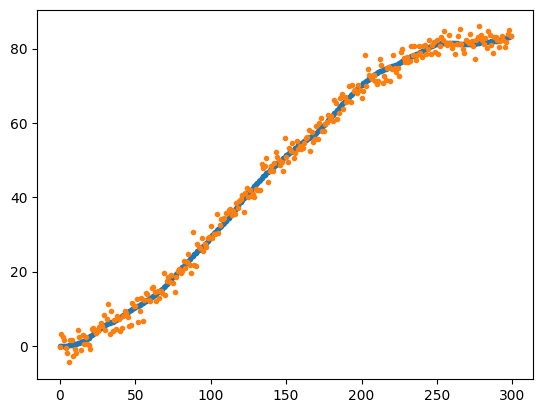

In [219]:
plt.plot(X1, '.') 
plt.plot(Y1, '.')
plt.show()

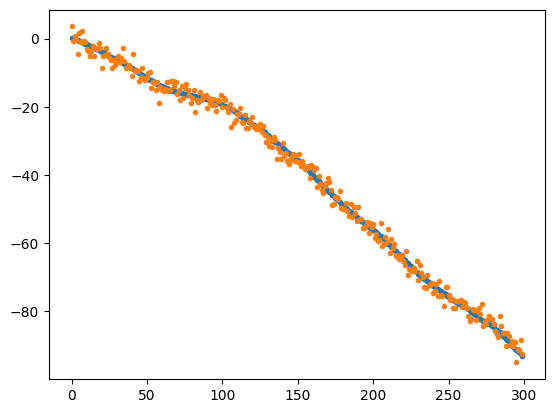

In [220]:
plt.plot(X2,'.') 
plt.plot(Y2,'.')
plt.show()

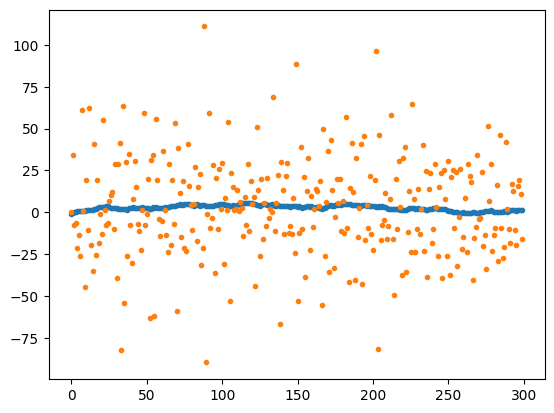

In [221]:
plt.plot(X3,'.') 
plt.plot(V1,'.')
plt.show()

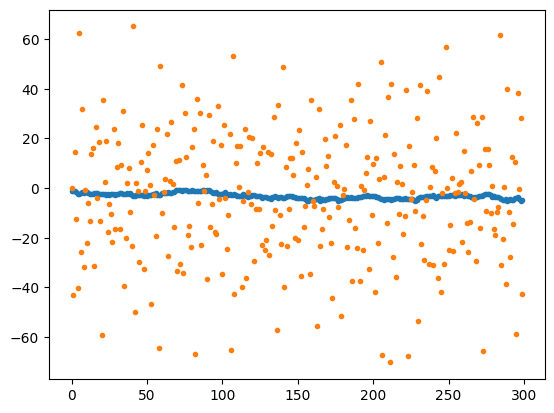

In [222]:
plt.plot(X4,'.') 
plt.plot(V2,'.')
plt.show()

### Kalman filter

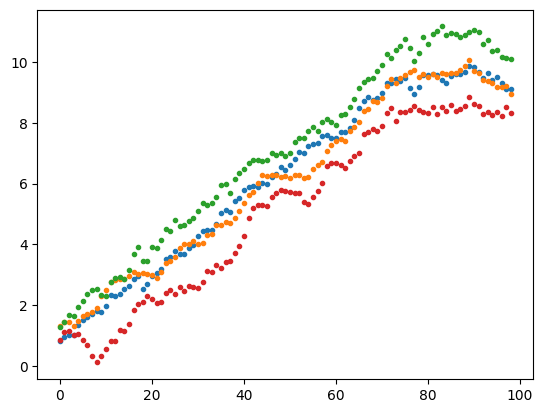

In [238]:
from dataclasses import dataclass
import time

dt = 0.1
A = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = [[4, 0], [0, 4]]
Q = [[(dt**3)/3, 0, (dt**2)/2, 0], [0, (dt**3)/3, 0, (dt**2)/2], [(dt**2)/2, 0, dt, 0], [0, (dt**2)/2, 0, dt]]

#data
t = 100
W = state_system(t) #+  np.random.multivariate_normal(np.zeros(2,1), R, t)
mean = [0, 0, 1, -1]

x0 = np.array([1, 0, 1, 0]).reshape(4,1)
m0 = x0

P0 = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
I = P0

Xe = []#np.zeros((4,t))
Pe = []

#print((W[0][0:2]).shape)
for i in range(1, t):

    Y = W[i][0:2] + np.random.multivariate_normal(mean, P0, 1)
    # prediction
    xp = np.dot(A,x0)
    Pp = np.dot(A,np.dot(P0,A.T))+Q
    
    #print(xp)
    #time.sleep(2)

    #correction
    S = np.dot(C,np.dot(Pp,C.T))+R
    K = np.dot(np.dot(Pp,C.T),np.linalg.inv(S))
    xc = xp + np.dot(K,Y-np.dot(C,xp))
    Pc = np.dot(I-np.dot(K,C),Pp)
    #print(xc)
    #time.sleep(5)
    Xe.append(xc)
    #Xe[:][i] = xc
    Pe.append(Pc)

    x0 = xc
    P0 = Pc

#for i in range(t):
 #   print(Xe[i][0])
 #   print(Xe[i][1])
#plt.plot(W[0:t][0],W[0:t][1],'.')


#print(Xe[0][0:t])
P1_corr=[z[0] for z in Xe]
P2_corr=[z[1] for z in Xe]
P3_corr=[z[2] for z in Xe]
P4_corr=[z[3] for z in Xe]

#print(P1_corr)
#print(P2_corr)

plt.plot(P1_corr,'.')

plt.show()





In [224]:
def state_system2(t):
    W = state_system(t)
    A = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
    mean = [0, 0, 1, -1]
    cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
    # x prediction before 
    X_b = [0]
    # x prediction after
    X_a = [np.random.multivariate_normal(mean, cov, 1).T]
    K = [A[0:2]]
    C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    P_b = [A]
    P_a = [A]
    R = [[4, 0], [0, 4]]
    Q = [[(dt**3)/3, 0, (dt**2)/2, 0], [0, (dt**3)/3, 0, (dt**2)/2], [(dt**2)/2, 0, dt, 0], [0, (dt**2)/2, 0, dt]]
    for i in range(1, t):
        P_b.append(np.dot(np.dot(A, P_a[i-1]), A.T) + Q)
        K.append(np.dot(np.dot(P_b[i], C.T), np.linalg.inv(np.dot(np.dot(C, P_b[i]), C.T) + R)))
        # Prediction :
        X_b.append(np.dot(A, X_a[i-1]))
        P_a.append(np.dot((cov-np.dot(K[i], C)), P_b[i]))
        # Correction :
        X_a.append(X_b[i] + np.dot(K[i], W[i][0:2] + np.random.multivariate_normal(mean, cov, 1) - X_b[i][0:2]))
    return X_a, P_a


    print()

### Smooth Kalman

In [ ]:
#initialization for X and P correction smooth
X_cor_s = np.zeros((4,N))
P_cor_s = np.zeros((4,4))

Ps = list()
for k in range(N-1, -1, -1):
    #correction smooth
    if k == N-1:
        X_cor_s[:, k] = Xe[:,k]
        P_cor_s = pc[k]
    else:
        xp=np.dot(A,Xe[:,k])
        pp=np.dot(A,np.dot(pc[k],A.T))+Q
        G = np.dot(pc[k], np.dot(A.T, inv(pp[k])))
        X_cor_s[:,k] = Xe[:, k] + np.dot(G, (X_cor_s[:,k+1] -xp))
        P_cor_s = pc[k] + np.dot(G, np.dot((P_cor_s - pp[k+1]), G.T))
    Ps.append(P_cor_s)
    
Ps = np.array(Ps)

In [ ]:
Ps.shape

In [ ]:
plt.figure(figsize=(16,12))
plt.style.use('Solarize_Light2')

plt.plot(X_cor_s[0,:], X_cor_s[1,:], label='(X_s[0], X_s[1])')
plt.legend()
plt.show()